## Problem 1 - 1D unconstrained optimization

### (a). Write a functioning one-dimensional black box unconstrained function optimizer.

In [1]:
%matplotlib inline

In [2]:
import timeit
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
import seaborn as sns

Here we will use the Fibonacci method for optimization. Our function will return a couple of useful values:
* $x^*$
* $f(x^*)$
* number of function calls for $f(x)$

In [3]:
def fib_min(f, x_1, x_4, n):
    I_0 = np.abs(x_4 - x_1)  # Initial interval of uncertainty
    c = (np.sqrt(5) - 1) / 2
    s = (1 - np.sqrt(5)) / (1 + np.sqrt(5))
    alpha = (c*(1 - s**n)) / (1 - s**(n+1))
    x_3 = alpha*x_4 + (1 - alpha)*x_1
    f_3 = f(x_3)
    
    for i in range(1, n+1):
        x_2 = 0.01*x_1 + 0.99*x_3 if i == n else alpha*x_1 + (1 - alpha)*x_4
        
        f_2 = f(x_2)
        if f_2 < f_3:
            x_4 = x_3
            x_3 = x_2
            f_3 = f_2
        else:
            x_1 = x_4
            x_4 = x_2
        alpha = (c*(1 - s**(n-i))) / (1 - s**(n-i+1))
        
    x_star = np.median([x_1, x_2, x_3, x_4])
    f_star = f(x_star)
    ncalls = f.called()
    f.reset()
    return(x_star, f_star, ncalls)

### (b). Test code of part (a). on two different 1D unconstrained optimization problems, with optimization starting points drawn from a probability distribution.

First, let's create a little helper function to keep track of the number of function calls

In [4]:
# Helper function to count function calls
def count(f):
    def call(*args,**kargs):
        call.calls += 1
        return f(*args,**kargs)

    call.calls = 0
    def reset(): call.calls = 0 
    call.reset = reset
    call.called = lambda : call.calls
    return call

Let's make up some functions, $f(x)$, to optimize:
* $f_{1}(x) = x^2 + 2x \:$  (quadratic)
* $f_{2}(x) = x^3 - 13x^2 + 36 \:$  (non-quadratic)

Let's also plot the functions to have a general sense of the interval to use for our optimizer

In [5]:
@count
def f_1(x):
    return x**2 + 2*x

@count
def f_2(x):
    return x**3 - 3*x**2 + 36

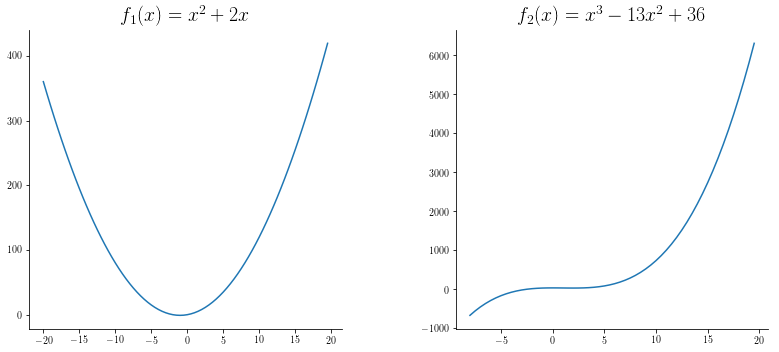

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
x1 = np.arange(-20, 20, 0.5)
x2 = np.arange(-8, 20, 0.5)

ax1.plot(x1, f_1(x1))
ax1.set_title(r"$f_{1}(x) = x^2 + 2x$", size=20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2.plot(x2, f_2(x2))
ax2.set_title(r'$f_{2}(x) = x^3 - 13x^2 + 36$', size=20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.subplots_adjust(wspace=10)
plt.tight_layout()
#plt.savefig('/home/hflores/uci/fall2017/optimization/hw1/functions.eps', format='eps', dpi=1000)

We now need to determine the starting points for our optimizer and determine the number of iterations or stopping conditions. For simplicity, let us obtain $x^*$ such that $f(x^*)$ is within $1\%$ of the true optimum.

$$\begin{aligned}
\frac{I_n}{2I_0} &\leq \frac{1}{100}\\
\frac{I_n}{I_0}  &\leq \frac{1}{50}\\
\frac{1}{F_n}    &\leq \frac{1}{50}\\
F_n              &\geq 50
\end{aligned}$$

Let us now obtain $n$ from the fibonacci sequence using Binet's formula

In [7]:
def fib(n):
    return (((1 + np.sqrt(5)) / 2)**n - ((1 - np.sqrt(5)) / 2)**n) / np.sqrt(5)

for n in range(2, 100):
    fib_n = fib(n)
    if fib_n >= 50:
        print('n = {}\nfib_n = {}'.format(n, fib_n))
        break

n = 10
fib_n = 55.000000000000014


Let us now create some random samples for our starting points. We'll draw from uniform distribution and sample from the interval $[-100, 100)$

In [8]:
# Set random seed
np.random.seed(13)

# Create samples
f1_samples = np.random.normal(loc=-1, scale=1, size=(20, 2))
f2_samples = np.random.normal(loc=8, scale=1, size=(20, 2))

In [9]:
# Override template to get return value of our function
timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

We are all setup for running our simulation. Let us gather the results for $f_1$ and $f_2$. Finally we wan't to gather some basic statistics (i.e. mean, std. dev) and plot our results

In [10]:
n = 10
f1_setup = 'from __main__ import fib_min, f_1, s, n'
f1_test = 'fib_min(f_1, s[0], s[1], n)'
f1_results = []

for s in f1_samples:
    f1_results.append(timeit.timeit(stmt=f1_test, setup=f1_setup, number=1))

In [11]:
n = 10
f2_setup = 'from __main__ import fib_min, f_2, s, n'
f2_test = 'fib_min(f_2, s[0], s[1], n)'
f2_results = []

for s in f2_samples:
    f2_results.append(timeit.timeit(stmt=f2_test, setup=f2_setup, number=1))

In [12]:
# Create matrix of results for easier computation
f1_mat = np.array([list([e[1][0], e[1][1], e[1][2], e[0]]) for e in f1_results])
f2_mat = np.array([list([e[1][0], e[1][1], e[1][2], e[0]]) for e in f2_results])

In [13]:
f1_df = pd.DataFrame(f1_mat)
f2_df = pd.DataFrame(f2_mat)

f1_df.columns = f2_df.columns = ['x*', 'f(x*)', 'function_calls', 'clock_time']

In [14]:
f1_df

,x*,f(x*),function_calls,clock_time
0,-1.003858,-0.999985,13.0,0.000658
1,-0.999863,-1.000000,12.0,0.000193
2,-0.458484,-0.706761,12.0,0.000178
3,-0.133349,-0.248917,12.0,0.000170
4,-0.995906,-0.999983,12.0,0.000168
5,-1.794326,-0.369046,12.0,0.000261
6,-0.998712,-0.999998,12.0,0.000162
7,-0.675915,-0.894969,12.0,0.000158
8,-0.849852,-0.977456,12.0,0.000162
9,-0.998391,-0.999997,12.0,0.000157


In [15]:
f1_df['x*'].describe()

count    20.000000
mean     -0.947108
std       0.351413
min      -1.794326
25%      -1.007333
50%      -0.998551
75%      -0.832188
max      -0.133349
Name: x*, dtype: float64

In [16]:
f1_df['f(x*)'].describe()

count    20.000000
mean     -0.879886
std       0.216419
min      -1.000000
25%      -0.999984
50%      -0.999891
75%      -0.869324
max      -0.248917
Name: f(x*), dtype: float64

In [17]:
f1_df['function_calls'].describe()

count    20.000000
mean     12.050000
std       0.223607
min      12.000000
25%      12.000000
50%      12.000000
75%      12.000000
max      13.000000
Name: function_calls, dtype: float64

In [18]:
f1_df['clock_time'].describe()

count    20.000000
mean      0.000248
std       0.000134
min       0.000153
25%       0.000158
50%       0.000174
75%       0.000295
max       0.000658
Name: clock_time, dtype: float64

In [19]:
print(f1_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &        x* &     f(x*) &  function\_calls &  clock\_time \\
\midrule
0  & -1.003858 & -0.999985 &            13.0 &    0.000658 \\
1  & -0.999863 & -1.000000 &            12.0 &    0.000193 \\
2  & -0.458484 & -0.706761 &            12.0 &    0.000178 \\
3  & -0.133349 & -0.248917 &            12.0 &    0.000170 \\
4  & -0.995906 & -0.999983 &            12.0 &    0.000168 \\
5  & -1.794326 & -0.369046 &            12.0 &    0.000261 \\
6  & -0.998712 & -0.999998 &            12.0 &    0.000162 \\
7  & -0.675915 & -0.894969 &            12.0 &    0.000158 \\
8  & -0.849852 & -0.977456 &            12.0 &    0.000162 \\
9  & -0.998391 & -0.999997 &            12.0 &    0.000157 \\
10 & -1.006449 & -0.999958 &            12.0 &    0.000155 \\
11 & -1.009986 & -0.999900 &            12.0 &    0.000286 \\
12 & -0.998913 & -0.999999 &            12.0 &    0.000158 \\
13 & -1.293503 & -0.913856 &            12.0 &    0.000154 \\
14 & -0.989732 & -0.999895 

In [20]:
f2_df

,x*,f(x*),function_calls,clock_time
0,7.699171,314.553840,13.0,0.000351
1,7.630426,305.599131,12.0,0.000205
2,7.940157,347.457533,12.0,0.000125
3,7.030768,235.247719,12.0,0.000120
4,7.778227,325.086647,12.0,0.000154
5,7.676198,311.540361,12.0,0.000496
6,7.471320,285.591838,12.0,0.000199
7,9.357814,592.745461,12.0,0.000191
8,7.949493,348.780494,12.0,0.000192
9,7.497876,288.862239,12.0,0.000185


In [21]:
f2_df['x*'].describe()

count    20.000000
mean      7.650571
std       0.664623
min       6.089015
25%       7.426863
50%       7.599981
75%       7.818709
max       9.357814
Name: x*, dtype: float64

In [22]:
f2_df['f(x*)'].describe()

count     20.000000
mean     316.683936
std       92.297258
min      150.528652
25%      280.291956
50%      301.706922
75%      330.679369
max      592.745461
Name: f(x*), dtype: float64

In [23]:
f2_df['function_calls'].describe()

count    20.000000
mean     12.050000
std       0.223607
min      12.000000
25%      12.000000
50%      12.000000
75%      12.000000
max      13.000000
Name: function_calls, dtype: float64

In [24]:
f2_df['clock_time'].describe()

count    20.000000
mean      0.000220
std       0.000096
min       0.000120
25%       0.000183
50%       0.000189
75%       0.000201
max       0.000496
Name: clock_time, dtype: float64

In [25]:
print(f2_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &        x* &       f(x*) &  function\_calls &  clock\_time \\
\midrule
0  &  7.699171 &  314.553840 &            13.0 &    0.000351 \\
1  &  7.630426 &  305.599131 &            12.0 &    0.000205 \\
2  &  7.940157 &  347.457533 &            12.0 &    0.000125 \\
3  &  7.030768 &  235.247719 &            12.0 &    0.000120 \\
4  &  7.778227 &  325.086647 &            12.0 &    0.000154 \\
5  &  7.676198 &  311.540361 &            12.0 &    0.000496 \\
6  &  7.471320 &  285.591838 &            12.0 &    0.000199 \\
7  &  9.357814 &  592.745461 &            12.0 &    0.000191 \\
8  &  7.949493 &  348.780494 &            12.0 &    0.000192 \\
9  &  7.497876 &  288.862239 &            12.0 &    0.000185 \\
10 &  7.477308 &  286.326859 &            12.0 &    0.000276 \\
11 &  6.089015 &  150.528652 &            12.0 &    0.000192 \\
12 &  8.458776 &  426.580208 &            12.0 &    0.000185 \\
13 &  7.625984 &  305.026966 &            12.0 &    0.000192 